# Predicting credit default

In this notebook we show how one can predict whether a customer will default on the repayment of their credit card loans using the KNN model. We will use the prepared dataset from the EDA notebook for this.

## Dataset preparation

In [1]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.model_selection import PredefinedSplit, GridSearchCV
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import f1_score, recall_score, precision_score, precision_recall_curve
import matplotlib.pyplot as plt
from plotnine import *
import os
import datetime
import pickle
import json
from pathlib import Path

from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all" # to make jupyter print all outputs, not just the last one
from IPython.core.display import HTML # to pretty print pandas df and be able to copy them over (e.g. to ppt slides)
pd.options.display.float_format = '{:.4f}'.format

In [2]:
# first we read in the parquet file with the input features
credit_card_df = pd.read_parquet(os.path.join('..', '..', 'datasets', 'computed', 'credit_risk_modelling_dataset.parquet'))

In [3]:
credit_card_df.head()

,id,limit_bal,sex,education,marriage,age,pay_1,pay_2,pay_3,pay_4,...,bill_amt6,pay_amt1,pay_amt2,pay_amt3,pay_amt4,pay_amt5,pay_amt6,default,max_delay,freq_delay
0,1,20000,2,2,1,24,2,2,-1,-1,...,0,0,689,0,0,0,0,1,2,2
1,2,120000,2,2,2,26,-1,2,0,0,...,3261,0,1000,1000,1000,0,2000,1,2,5
2,3,90000,2,2,2,34,0,0,0,0,...,15549,1518,1500,1000,1000,1000,5000,0,0,6
3,4,50000,2,2,1,37,0,0,0,0,...,29547,2000,2019,1200,1100,1069,1000,0,0,6
4,5,50000,1,2,1,57,-1,0,-1,0,...,19131,2000,36681,10000,9000,689,679,0,0,4


# Creating the train, test, and validation splits

- **We split the dataset into train, validation, and test**

- We will set test aside, which will be used to evaluate the final performance of the model. Then we will use train and validation to fit the actual model.

- Note that since our dataset is imbalanced, we must make sure that the distribution of the target across train, validation, and test is balanced, otherwise we run the risk of e.g. not have sufficient default cases in the test set, for instance.

- The reason why we split the data into train, validation, and test is that we want to train the model and then evaluate the model accuracy on data **that the model has never seen**. This is the only way to accurately evaluate the predictive performance of a model.

- There are no hard-and-fast rules on how you have to split the data into train, validation, and test, only rules of thumb. The general idea is that you should have enough training examples to minimize the variance (uncertainty) on the model parameters, and enough test examples to minimize the variance (uncertainty) on the model performance metrics

- If there is enough data, the following algorithm to split into train/validation/test is the standard one:
    - split the dataset into fitting data (80%) and test set (20%)
    - split the fitting data further into train set (80% of the fitting data) and validation set (20% of the fitting data)
- If there is not enough data, then crossvalidation is the only option in order to find the best model parameters

# Software engineering intermezzo: object oriented programming basics

In this course, we focus on model building rather than programming patterns, but in a **real** machine learning project the software engineering/IT part of the project is typically as important as the modelling part (and sometimes more...). One important programming pattern that every data scientist should know is *object oriented programming*. In the code we have seen until now, we mostly worked with python functions. However, sometimes one would like to have a way to combine multiple functions and some data into a single unit of behaviour.

For instance, consider the task of modelling a bank customer. This *entity* could be modelled as a dictionary where we store, e.g., the customer name, his date of birth, and the balance of his bank account.

In [4]:
customer = {
    "balance": 1000,
    "name": "John",
    "birthdate": "1980-01-01"
}

Now, there are many things we might want to do with customers. For instance, we might want to change their balance when they make a transaction. We could do that with a function set_balance, for instance.

In [5]:
def set_balance(customer, new_balance):
    customer["balance"] = new_balance

set_balance(customer, 500)
customer

{'balance': 500, 'name': 'John', 'birthdate': '1980-01-01'}

That's great. However, there are many other operations we might want to do on a customer. For instance, we might want to:

1. Calculate the current age of the customer
2. Change the customer name

And many others. If we had a function for each operation we want to do on the customer, this might start being rather messy, in particular if the functions change the **state** of the customer object, e.g., by resetting the balance of the customer. Consider that in a realistic scenario we might have millions of customers and you can see the problem.

In **object oriented programming**, we deal with this problem by defining a customer **class** which we can use to create individual customers.

This class is essentially a template/blueprint to create customer objects. It specifies which data attributes the customer objects have (like birthdate, name, etc.). It also specifies which **methods** the customer objects have. Methods are like functions, but they are bound to a specific class object and they act/modify that object. When we have a class, we can create objects from it simply by calling it, and passing to it the values of the attributes (e.g. balance) that we want the new object to have. These values are passed to a special __init__ method, which then sets the passed arguments on the object.

The following is an example of a customer class with an init method and a couple of the methods discussed above:

In [6]:
class Customer():
    def __init__(self, balance, name, birthdate) -> None:
        self.name = name
        self.balance = balance
        self.birthdate = birthdate
        
    def set_balance(self, new_balance):
        self.balance = new_balance
        
    def change_name(self, new_name):
        self.name = new_name
        
# with this class, we can now create a customer object
customer1 = Customer(balance=1000, name="John", birthdate="1980-01-01")
# but we can use the class to create multiple customers, with different attribute values
customer2 = Customer(balance=400, name="Andy", birthdate="1991-05-16")
customer3 = Customer(balance=100, name="Pamela", birthdate="1960-03-20")

# we can then call the methods on the specific customers to change/get values for that customer
print("Customer 1 initial balance: {}".format(customer1.balance))
customer1.set_balance(1500)
print("Customer 1 new balance: {}".format(customer1.balance))

Customer 1 initial balance: 1000
Customer 1 new balance: 1500


Note how the class is called with the values of the attributes that you want to use when you create the customer object. These are passed to the __init__ method, which then creates the customer object. Note moreover how every method in the class has a `self` argument. This argument refers to the specific customer object instance that we have when we call the method on a customer instance, and can be used to e.g. change the attribute values of that customer instance.

The entire sklearn library that we use for machine learning in this course is build on object oriented programming, so it's important to have at least an idea of what that is. 

Moreover, in the neural network section we will see how to implement a transformer model with pytorch, which is also based on object oriented programming.

Now that we have seen an abstract example, we can see a more concrete example by using object oriented programming to split our data into training, validation, and test set.

In [7]:
class TrainTestSplitter(object):
    '''Class to perform the split of the data into train, test, and validation.
    '''
    def __init__(self, train_frac=0.8, validation_frac=0.2, seed=1234):
        self.train_frac = train_frac
        self.validation_frac = validation_frac
        self.seed = seed
    
    def calculate_statistics(self):
        statistics = {}
        for i in ['train_set', 'test_set', 'validation_set']:
            split_stats = {}
            default_count = (getattr(self, i).groupby('default').size().reset_index())
            split_stats['N_defaults'] = (default_count.loc[lambda x: x.default ==1, 0].iloc[0])
            split_stats['percentage_total_defaults'] = split_stats['N_defaults']/self.total_n_defaults * 100
            split_stats['N_not_defaults'] = default_count.loc[lambda x: x.default == 0, 0].iloc[0]
            split_stats['percentage_total_not_defaults'] = split_stats['N_not_defaults']/self.total_n_not_defaults * 100
            statistics[i] = split_stats
        self.split_statistics = statistics

    def split_train_test(self, df):
        print("Generating the train/validation/test splits...")
        self.total_n_defaults = df.loc[lambda x: x.default == 1].shape[0]
        self.total_n_not_defaults = df.loc[lambda x: x.default == 0].shape[0]
        self.train_set = df.sample(frac=self.train_frac, random_state=self.seed)
        self.test_set = df.loc[lambda x: ~x.id.isin(self.train_set.id)].reset_index(drop=True)
        self.validation_set = self.train_set.sample(frac=self.validation_frac).reset_index(drop=True)
        self.train_set = self.train_set.loc[lambda x: ~x.id.isin(self.validation_set.id)].reset_index(drop=True)
        print("calculating the statistics...")
        self.calculate_statistics()
        print("split completed")

In [8]:
# create a fitting_splits object that will hold the train, validation, and test data
fitting_splits = TrainTestSplitter()

In [9]:
# now we can call the split_train_test method on the fitting_splits object to split the data into train, validation, and test
fitting_splits.split_train_test(credit_card_df)

Generating the train/validation/test splits...
calculating the statistics...
split completed


In [10]:
fitting_splits.test_set.shape

(6000, 27)

In [11]:
fitting_splits.split_statistics

{'train_set': {'N_defaults': np.int64(4270),
  'percentage_total_defaults': np.float64(64.34599156118144),
  'N_not_defaults': np.int64(14930),
  'percentage_total_not_defaults': np.float64(63.90172915596645)},
 'test_set': {'N_defaults': np.int64(1307),
  'percentage_total_defaults': np.float64(19.695599758890896),
  'N_not_defaults': np.int64(4693),
  'percentage_total_not_defaults': np.float64(20.086457798322204)},
 'validation_set': {'N_defaults': np.int64(1059),
  'percentage_total_defaults': np.float64(15.958408679927668),
  'N_not_defaults': np.int64(3741),
  'percentage_total_not_defaults': np.float64(16.01181304571135)}}

Consider the split statistics above, and note how we have ~64% of the default cases in the training set, ~20% of the default cases in the test set, and ~16% of the default cases in the validation set. We conclude that the split is representative of the class balances, and we can proceed with modelling.

# Dummification and scaling

Before fitting a model to our data, we need to deal with two data transformations that are **essential** to be able to obtain a performant model. These are **dummification** or **one-hot-encoding** and **scaling**.

### Dummification
- **Dummification** is used to transform categorical variables into numerical variables, since most machine learning models can only deal with numerical variables. You probably already encountered this in your statistics course since linear regression requires dummification.
- In dummification, we transform a categorical variable with N values into C_0, ..., C_N columns that take only 0 or 1 values. A row then has exactly one of these columns with 1, and the others with 0, namely, the column corresponding to the original value of the categorical variable for that row.
- Note that there are alternative ways to deal with categorical variables. One is to use ordinal encoding, which simply encodes the categorical variable as integers. In the above dataset, the categorical variables of education, gender, marriage, etc. are ordinally encoded
- Ordinal encoding, however, introduces an order between the categories which doesn't necessarily make sense and can cause problems for ML algorithms. For instance, if we have two categories "male" and "female", and we encode them as 0 and 1, then we are also encoding that "male" < "female" since 0 < 1. Which does not make sense and can lead to issues with the models, for instance predictions in-between classes
- In our dataset, one might argue that while there is a natural order for education, no such order exists for sex and marriage. Therefore, we are going to one-hot encode the sex and marriage variables

We will use the sklearn one hot encoder to encode the sex and marriage variables. The education variable we will leave as an ordinal (integer) variable. See
https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.OneHotEncoder.html for documentation.

### Scaling
- **feature scaling** refers to the application of a transformation to the numerical variables in the dataset which normalizes the range of the numerical variables, ensuring that these ranges are the same
- this is performed because often numerical variables can have wildly different ranges; for instance, the "age" variable in the above dataset has a very different range from the "limit_bal" variable.
- this can cause problems to machine learning models, in particular those, like SVM, that rely on measuring distances in e.g. Euclidean spaces. Without scaling, features whose range is in the high numers (e.g. limit_bal) will come to dominate the distance measures used in the algorithms, and features with ranges in the low numbers (e.g. age) will have little to no impact on the model
- there are many ways to standardize variables (https://en.wikipedia.org/wiki/Feature_scaling). The most common are:
    - min/max scaling
    - mean normalization
    - standardization (z-score calculation)

sklearn provides various classes to perform feature scaling. We are going to use the StandardScaler, which performs z-score standardization. See https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.StandardScaler.html for documentation.

In [12]:
# 1. fit a one hot encoder transformer to the TRAIN SET. The object we obtain will be reused later, to transform our data
# note: it is important that these transformers are fitted only on the train data.
one_hot_encoder = OneHotEncoder() # one hot encoder is a class instance
_ = one_hot_encoder.fit(fitting_splits.train_set[['sex', 'marriage']]) # we can fit the encoder instance on the columns that need to be transformed.

In [13]:
# let's check what the encoder did
one_hot_encoder.categories_ # after we fit the encoder, the instance learns which values are present in each data column.
encoded_names = one_hot_encoder.get_feature_names_out() # with this method we can retrieve the names of the new dummy columns that have been computed
encoded_names
encoded_categories = one_hot_encoder.transform(fitting_splits.train_set[['sex', 'marriage']]).toarray() # at this point, we can use the fitted encoder to transform any array with a sex and marriage column; not just the training set, but also the validation or test set. The encoder will take that array of shape (M,2) and transform it to an array of shape (M, N), where N is the total number of distinct possible values for the encoded features. The values of the new array will be either 0 or 1, encoding whether that value of the feature applies to the row.
df_encoded = pd.DataFrame(encoded_categories)
df_encoded.columns = encoded_names
df_encoded

[array(['1', '2'], dtype=object), array(['0', '1', '2', '3'], dtype=object)]

array(['sex_1', 'sex_2', 'marriage_0', 'marriage_1', 'marriage_2',
       'marriage_3'], dtype=object)

,sex_1,sex_2,marriage_0,marriage_1,marriage_2,marriage_3
0,1.0000,0.0000,0.0000,1.0000,0.0000,0.0000
1,1.0000,0.0000,0.0000,0.0000,1.0000,0.0000
2,0.0000,1.0000,0.0000,1.0000,0.0000,0.0000
3,0.0000,1.0000,0.0000,1.0000,0.0000,0.0000
4,1.0000,0.0000,0.0000,0.0000,1.0000,0.0000
...,...,...,...,...,...,...
19195,0.0000,1.0000,0.0000,1.0000,0.0000,0.0000
19196,0.0000,1.0000,0.0000,0.0000,1.0000,0.0000
19197,1.0000,0.0000,0.0000,0.0000,1.0000,0.0000
19198,1.0000,0.0000,0.0000,1.0000,0.0000,0.0000


In [14]:
# after we have generated the dummy columns, we want to drop the original columns from the training data, and replace them with the dummy columns
train_set = fitting_splits.train_set.drop(['sex', 'marriage'], axis=1)
train_set = pd.concat([train_set, df_encoded], axis=1)
train_set

,id,limit_bal,education,age,pay_1,pay_2,pay_3,pay_4,pay_5,pay_6,...,pay_amt6,default,max_delay,freq_delay,sex_1,sex_2,marriage_0,marriage_1,marriage_2,marriage_3
0,13126,400000,1,34,-2,-2,-2,-2,-2,-2,...,0,0,-2,0,1.0000,0.0000,0.0000,1.0000,0.0000,0.0000
1,14636,80000,2,34,0,0,0,0,0,0,...,2000,0,0,6,1.0000,0.0000,0.0000,0.0000,1.0000,0.0000
2,4382,20000,2,41,-1,-1,-1,-1,-1,-1,...,0,0,-1,0,0.0000,1.0000,0.0000,1.0000,0.0000,0.0000
3,7660,70000,1,36,2,0,0,0,0,0,...,0,0,2,6,0.0000,1.0000,0.0000,1.0000,0.0000,0.0000
4,10638,50000,2,24,0,0,0,0,0,0,...,1000,0,0,6,1.0000,0.0000,0.0000,0.0000,1.0000,0.0000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
19195,5299,200000,2,29,0,0,0,0,0,0,...,44701,0,0,6,0.0000,1.0000,0.0000,1.0000,0.0000,0.0000
19196,6120,50000,2,24,2,0,0,2,2,2,...,2200,1,2,6,0.0000,1.0000,0.0000,0.0000,1.0000,0.0000
19197,63,50000,1,29,2,2,2,2,2,2,...,0,1,2,6,1.0000,0.0000,0.0000,0.0000,1.0000,0.0000
19198,3498,240000,2,37,-1,-1,-1,0,0,0,...,21257,0,0,3,1.0000,0.0000,0.0000,1.0000,0.0000,0.0000


In [15]:
# now we fit the StandardScaler, in order to standardize all the features
standard_scaler = StandardScaler()
standard_scaler = standard_scaler.fit(train_set)

# the above standard scaler, when apply to a dataset with the same columns as the train set, will scale all the numerical features and return a numpy array
standard_scaler.transform(train_set)

array([[-0.21719118,  1.78329693, -1.07405984, ...,  1.09191636,
        -1.06480398, -0.10490573],
       [-0.04305544, -0.67547135,  0.18314609, ..., -0.91582106,
         0.93913999, -0.10490573],
       [-1.22556394, -1.1364904 ,  0.18314609, ...,  1.09191636,
        -1.06480398, -0.10490573],
       ...,
       [-1.72363827, -0.90598088, -1.07405984, ..., -0.91582106,
         0.93913999, -0.10490573],
       [-1.3275083 ,  0.55391279,  0.18314609, ...,  1.09191636,
        -1.06480398, -0.10490573],
       [-1.18981422, -0.67547135, -1.07405984, ..., -0.91582106,
         0.93913999, -0.10490573]])

**Note** In the code above, I am scaling the dummified features. This is not really necessary and it's actually not best practice: it would be a lot better to scale the other features, but leave the dummy columns unscaled as they are already between 0-1.

**Exercise**: How can we modify the code above so that we don't scale the dummy features?

Once we have a one hot encoder and a standard scaler fitted on the training data, it is handy to combine all the transformations needed to prepare a dataset with the same schema as the training dataset into a function. This is so that we can apply it to training/validation/test easily, and any new dataset with the same columns that we might get in the future.

In [16]:
def dummify(df, one_hot_encoder):
    vars_to_encode = ['sex', 'marriage']
    df_to_encode = df[vars_to_encode]
    if not one_hot_encoder:
        one_hot_encoder = OneHotEncoder()
        df_encoded = one_hot_encoder.fit_transform(df_to_encode).toarray()
    else:
        df_encoded = one_hot_encoder.transform(df_to_encode).toarray()
    df_encoded = pd.DataFrame(df_encoded)
    df_encoded.columns = one_hot_encoder.get_feature_names_out()
    # add the encoded columns and drop the original columns
    df = df.drop(vars_to_encode,axis=1)
    df = pd.concat([df, df_encoded], axis=1)
    return df, one_hot_encoder

def scale(df, standard_scaler):
    cols = df.columns
    if not standard_scaler:
        standard_scaler = StandardScaler()
        df = standard_scaler.fit_transform(df)
    else:
        df = standard_scaler.transform(df)
    df = pd.DataFrame(df)
    df.columns = cols
    return df, standard_scaler

def prepare_data(df, one_hot_encoder=None, standard_scaler=None):
    df = df.reset_index(drop=True)
    df, one_hot_encoder = dummify(df, one_hot_encoder)
    df, standard_scaler = scale(df, standard_scaler)
    return df, one_hot_encoder, standard_scaler

In [17]:
# now we prepare all the data we use below
X_train, one_hot_encoder, standard_scaler = prepare_data(fitting_splits.train_set)
X_train = X_train.drop(["default", "id"],axis=1)  # need to drop the target! otherwise data leakage
y_train = fitting_splits.train_set["default"]

X_validation = prepare_data(fitting_splits.validation_set, one_hot_encoder, standard_scaler)[0]
X_validation = X_validation.drop(["default", "id"],axis=1)
y_validation = fitting_splits.validation_set["default"]

X_test = prepare_data(fitting_splits.test_set, one_hot_encoder, standard_scaler)[0].drop(["default", "id"],axis=1)
y_test = fitting_splits.test_set["default"]

X_train_validation = pd.concat([X_train, X_validation])
y_train_validation = pd.concat([y_train, y_validation])

In [18]:
# we now store all the relevant data in a dictionary, so that we can save it to disk for later use

data_dictionary = {
    "X_train": X_train,
    "y_train": y_train,
    "X_validation": X_validation,
    "y_validation": y_validation,
    "X_test": X_test,
    "y_test": y_test,
    "one_hot_encoder": one_hot_encoder,
    "standard_scaler": standard_scaler
}

# we can store the dictionary to disk using the pickle module as follows:
data_dictionary_path = os.path.join('..', '..', 'datasets', 'computed', 'credit_risk_splits.pickle')

with open(data_dictionary_path, 'wb') as f:
    pickle.dump(data_dictionary, f)

## Modeling with a new model: SVC

Now, we can move on to train some models.

We are first going to try a model that we have not seen in class.

This is useful because it's important for you to develop the ability to read the documentation of a new model and understand how to use it. This is a very important skill in data science, as there are many models out there, and you will often have to use models that you have never seen before. After this, we will use a model that we have seen in class, that is, the KNN model.

Note moreover that regardless of the model, the general structure of a supervised ML problem is always the same:

1. you prepare the data and do EDA
2. you split the data into train, validation, and test
3. you fit the model on the train and validation set with hyperparameter tuning
4. you evaluate the model on the test set to get an estimate of the model's performance on unseen data

The only thing that changes is the model that you fit to the data. The rest of the steps are always the same.

For svc, we are going to:

1. First, we are going to train a default SVC model on the train set, and use it to predict on the test set. This is just to illustrate the code and the steps involved in fitting and predicting with a model using sklearn.
2. Then we are going to evaluate the predictions that the above model generates on the test set. How is the model performing?
3. Then, we are going to:
    - perform a train-validation grid-search in the hyperparameter space of the SVC model (**hyperparameter tuning**)
    - choose the best set of hyperparameters among those explored
    - train a SVC model with the found hyperparameters on train + validation, and predict on test 
4. Finally, we are going to evaluate the predictions of the resulting model at point 3

### Simple train/test model

In [19]:
from sklearn.svm import SVC

# create the model instance
simple_SVC = SVC(gamma='auto', random_state=1234)

# fit the model instance on X_train
simple_SVC.fit(X=X_train, y=y_train)

SVC(gamma='auto', random_state=1234)

In [20]:
# now we can use the fitted simple_SVC model to predict on the test dataset!
y_hat_test = simple_SVC.predict(X_test)
# the result is a vector of predicted classes for the observations in validation, which the model was not trained on!
pd.Series(y_hat_test)

0       0
1       0
2       0
3       0
4       0
       ..
5995    0
5996    1
5997    1
5998    0
5999    0
Length: 6000, dtype: int64

In [21]:
pd.Series(y_hat_test).value_counts()
fitting_splits.test_set['default'].value_counts()

0    5340
1     660
Name: count, dtype: int64

default
0    4693
1    1307
Name: count, dtype: int64

We can already clearly see that the model is underpredicting the minority class and overpredicting on the majority class. Let's, however, look at the performance of the model in more detail (on the test set).

#### Evaluate the model performance

We can now evaluate the classification performance of the model on the test set.
There are various possible metrics that can be useful to evaluate the model performance. In particular, the following can be considered:

- accuracy score: the percentage of examples that was correctly classified (see https://scikit-learn.org/stable/modules/generated/sklearn.metrics.accuracy_score.html)
    - pros: simple to interpret and communicate to non-technical people
    - cons: it can be too simple and disguise bad performance as good performance, for instance in the case of imbalanced datasets

- confusion matrix: create the 2 x 2 confusion matrix, and use it to evaluate the model misclassifications:
   - pros: easy to interpret, visual, shows the difference in classification accuracy on the two classes
   - cons: it does not provide a single accuracy metrics, which is useful to compare multiple models against each other

<div>
<img src="../../img/confusion_matrix.png" width="400">
</div>

- evaluate the precision and recall of the classification separately:
    - precision: the % of the examples classified as positives (defaults) that are actually positive: TP / TP + FP
    - recall: the % of the actually positive examples (defaults) that was classified as positive: TP / TP + FN

- F1-score: the harmonic mean of the precision and recall scores (see above).
   - calculated as TP/(TP + 1/2(FP + FN)). Ranges between 0 and 1.
   - the higher the score, the better the model
   - weights false negatives and false positives equally (which might now always be what you want, as these can have different associated costs)
    - pros: it combines precision and recall into a single score that can be used to evaluate models
    - pros: realiable with imbalanced datasets
    - cons: it can be hard to explain to stakeholders. 

For the present exercise, we are going to use the F1-score to evaluate the classification accuracy. Sklearn has a handy function in the metrics module to calculate the F1 score, the f1_score function.

In [22]:
round(f1_score(y_test, y_hat_test), 2)

np.float64(0.45)

We got 0.44 ~ 0.45 as an F1 score with the default model. Is this good? Is this bad? These are in principle the wrong questions. An f1 score is a **relative** measure of accuracy, i.e., it is useful to compare different models against each other, and determine which one is the better classifier. But it's not useful by itself in isolation.

For instance, consider the simplest possible classification model: the model that classifies everything as 0 (no default). The F1 score of this model then is:

In [23]:
f1_score(y_test, np.zeros(fitting_splits.test_set.shape[0]))

np.float64(0.0)

According to the F1-score, this model sucks (it's the worst possible model), even though its accuracy might be quite high because of the imbalanced data. The F1 score is the correct measure here, but it's also telling us that the model above is a better model than this naive model.

Since we have an imbalanced dataset, we might want to do a quick try and see if we can improve the performance by balancing it. The quickest way to do this is to **downsample** the negative class so as to achieve balance. Let's see what happens.

In [24]:
# check out the distribution of the class in the train set
fitting_splits.train_set.groupby('default').size()

# we now downsample the negative class, choosing the same number of observations as we have for the positive class
# we then discard data and obtain a balanced dataset
train_set_sampled = fitting_splits.train_set.sample(4783, random_state=1234)

# after this the code is the same as above, to fit and predict with the model
train_set_transformed_sampled = prepare_data(train_set_sampled, one_hot_encoder=one_hot_encoder, standard_scaler=standard_scaler)
X_train_sampled = train_set_transformed_sampled[0].drop(['default', 'id'], axis=1) # Attention, we need to drop the target! Otherwise we have data leakage
y_train_sampled = train_set_sampled['default'] # take the target from the original, untransformed dataset

# create the model instance
simple_SVC = SVC(gamma='auto', random_state=1234)
# fit the model instance on X_train
simple_SVC.fit(X=X_train_sampled, y=y_train_sampled)

# predict on the test set
y_hat_test = simple_SVC.predict(X_test)

# the result is a vector of predicted classes for the observations in the test set, which the model was not trained on!
round(f1_score(y_test, y_hat_test), 2)

default
0    14930
1     4270
dtype: int64

SVC(gamma='auto', random_state=1234)

np.float64(0.43)

The f1 score of the above model is 0.43/0.44 (there might be some variation in your run of the code: this is normal, as there is some randomness involved in fitting the SVC algorithm). 

In other words, we didn't gain anything by downsampling, compared to the first basic model. That means that the benefit of making the training set balanced is outweighed by the loss of training examples.

Most likely, an approach like SMOTE (see the EDA notebook) would work better here.

### Hypertuning the SVC model

In the above, we have fitted and predicted with basically the default SVC model. However, each machine learning model comes with a set of **hyperparameters** that can be tuned. Think of a model as a machine, and of hyperparameters as levers and dials of the machine, which need to be set before it can used. In our case, the hyperparameters must be set before we can train and then predict with the model.

But how should we set these parameters? There is no way to set them from data, in the fitting process. Rather, we need to explore the space of possible values for these hyperparameters, and for each combination that we might want to try, fit a model and evaluate its predictive performance. The combination of hyperparameters values that returns the model with the highest performance is the optimal value of hyperparameters among the combination explored.

Note that model hyperparameters are different from model parameters. The main difference is that the latter are learned during the fitting process, and estimated directly from the data in this process. The model hyperparameters cannot be estimated in this way because they define the "shape" or "class" of the model before the training has taken place. See also https://machinelearningmastery.com/difference-between-a-parameter-and-a-hyperparameter/ for an explanation of the difference.

Often, a model will have many hyperparameters. Not all of them are important, or have the same impact on the performance of the model. So how do you determine which ones to tune? The only way is from experience, or by understanding the mathematics of the model and understanding which parameters matter the most, or by empirical research that has been done by other researchers

For SVMs, the most important parameters are:
- The kernel. This is the actual function that maps the observations to the (higher-dimensional) space. In the above, we used the default radial kernel, which is also that which performs the best most of the times
- for different kernels there might be different hyperparamters that can be tuned. These hyperparamters usually specify the shape of the transformation of the feature space. For the radial kernel, we have two important ones:
    - the gamma parameter
    - the C ('cost') parameter

You can find a good description of what these parameters control here: https://towardsdatascience.com/svm-hyperparameters-explained-with-visualizations-143e48cb701b, but for now it suffices to understand that these are parameters that control the shape of the model, and their values can have an impact on the model performance.

Let's say that we want to tune the gamma and C parameter to see if we get a better SVC model. There are various approach to do this, but the simplest is: **grid search**. 

- This means that we will create a grid with different combinations of values of the two parameters
- For each combination of hyperparameter values we fit a SVC model to the data with those hyperparameter values, and predict on the **validation** dataset
- The model which returns the best f1-score will show us what the best hyperparameters in the grid are
- We can then use these hyperparameters to train a final model on all the fitting data, and predict on the test set

<div>
<img src="../../img/hyperparameter_tuning.png" width="800">
</div>

In [25]:
USE_STORED_SVC_HYPERTUNED_MODELS = True
USE_STORED_SVC_SKLEARNED_HYPERTUNED_MODELS = True

# define the arrays for the C and gamma parameters that we are going to try. This is our "grid"
# Just trying 3 * 3 = 9 models here so it doesn't take too long
# with e.g. 10 values for each parameter we have already 10 * 10 = 100 models, which takes ~70 minutes on my pc.
C_range = [2 ** -5, 2 ** 15]
gamma_range = [2 ** -15, 2 ** 3]
C_grid = np.linspace(C_range[0], C_range[1], num=3)
gamma_grid = np.linspace(gamma_range[0], gamma_range[1], num=3)
C_grid
gamma_grid

array([3.12500000e-02, 1.63840156e+04, 3.27680000e+04])

array([3.05175781e-05, 4.00001526e+00, 8.00000000e+00])

In [26]:
# perform hypertuning. We will loop over all possible parameter value combinations, and train a model for each combination on the training set.
# this will take a long while! (77 minutes for 100 models on my machine with 14 cores, 4.5 minutes for 9 models) This is because the code is not optimized (see below), SVC is not the fastest of models, and the disadvantage of grid search is that
# it's exponentially expensive on the size of the parameter grid.

# Note: if this takes too long, it's always an option to reduce the size of the hyperparameters space considered.

def fit_svm_model(X_train, y_train, C, gamma):
    # create the model instance with the required parameters
    simple_SVC = SVC(gamma=gamma, C=C, random_state=1234)
    # fit the model instance on X_train
    simple_SVC.fit(X=X_train, y=y_train)
    return simple_SVC

# check if there are already hypertuned models. If yes, use them - unless the constant USE_STORED_SVC_HYPERTUNED_MODELS is set to true
if os.path.exists(Path("..", "..", "datasets", "computed", "hypertuning_models.pickle")) and USE_STORED_SVC_HYPERTUNED_MODELS is True:
    with open(Path("..", "..", "datasets", "computed", "hypertuning_models.pickle"), 'rb') as handle:
        fitted_models = pickle.load(handle)
else:
    print('could not find the hypetuning models on disk, or you requested to hypertune the models in this run')
    print('performing hypertuning')

    # will hold the models fitted on train, for each hyperparameter combination
    fitted_models = []

    # train a model for each hyperparameter combo
    print("begin hypertuning")
    start_time = datetime.datetime.now()
    for C in C_grid:
        for gamma in gamma_grid:
            # fit a model with the given hyperparameter values.
            # A new model will be fitted for each loop cycle
            print(f"fitting model for C: {C} and gamma: {gamma}")
            fitted_model = fit_svm_model(X_train, y_train, C, gamma)
            print(f"fitting complete.")
            # store the fitted model in the fitted_model list
            fitted_models.append(fitted_model)

    end_time = datetime.datetime.now()
    print(f'hypertuning complete in {round((end_time - start_time).seconds/60, 2)} minutes')

    # store the fitted models as a pickle so they can be analysed later with ease
    with open(Path("..", "..", "datasets", "computed", "hypertuning_models.pickle"), 'wb') as handle:
        pickle.dump(fitted_models, handle)

could not find the hypetuning models on disk, or you requested to hypertune the models in this run
performing hypertuning
begin hypertuning
fitting model for C: 0.03125 and gamma: 3.0517578125e-05
fitting complete.
fitting model for C: 0.03125 and gamma: 4.0000152587890625
fitting complete.
fitting model for C: 0.03125 and gamma: 8.0
fitting complete.
fitting model for C: 16384.015625 and gamma: 3.0517578125e-05
fitting complete.
fitting model for C: 16384.015625 and gamma: 4.0000152587890625
fitting complete.
fitting model for C: 16384.015625 and gamma: 8.0
fitting complete.
fitting model for C: 32768.0 and gamma: 3.0517578125e-05
fitting complete.
fitting model for C: 32768.0 and gamma: 4.0000152587890625
fitting complete.
fitting model for C: 32768.0 and gamma: 8.0
fitting complete.
hypertuning complete in 4.57 minutes


In [27]:
# note that each model we have trained is the instance of an oop class!!
fitted_models[0:5]

[SVC(C=np.float64(0.03125), gamma=np.float64(3.0517578125e-05),
     random_state=1234),
 SVC(C=np.float64(0.03125), gamma=np.float64(4.0000152587890625),
     random_state=1234),
 SVC(C=np.float64(0.03125), gamma=np.float64(8.0), random_state=1234),
 SVC(C=np.float64(16384.015625), gamma=np.float64(3.0517578125e-05),
     random_state=1234),
 SVC(C=np.float64(16384.015625), gamma=np.float64(4.0000152587890625),
     random_state=1234)]

Now that we have all the models fitted for each parameter combination, we can evaluate each fitted model on the validation dataset. The model which gives us the best f1 score on the validation dataset is the model with the best parameters combination.

In [28]:
# evaluate the F1 score of each model on validation, and find the best hyperparameters
def calculate_f1_score(X, y, model):
    y_hat = model.predict(X)
    return f1_score(y, y_hat)

f_scores = [calculate_f1_score(X_validation, y_validation, m) for m in fitted_models]

In [29]:
# take a peek at the top f1 scores
f_scores[:20]

[np.float64(0.0),
 np.float64(0.0),
 np.float64(0.0),
 np.float64(0.4301639344262295),
 np.float64(0.15907447577729572),
 np.float64(0.10501193317422435),
 np.float64(0.4383561643835616),
 np.float64(0.15907447577729572),
 np.float64(0.10501193317422435)]

In [30]:
# identify the model with the best F score value. This is the model which gives us the best parameters.
max_f1_score = max(f_scores)
best_model_index = f_scores.index(max_f1_score)
best_model = fitted_models[best_model_index]

In [31]:
print(f"The best value of C found is {best_model.C}")
print(f"The best value of gamma is {best_model.gamma}")
print(f"The best value of the f1 score on validation is {max_f1_score}")

The best value of C found is 32768.0
The best value of gamma is 3.0517578125e-05
The best value of the f1 score on validation is 0.4383561643835616


Now that we have identified the best parameters using the train and validation method, we can train a model with the best parameters on train + validation, and predict on test. This gives us the final out-of-sample performance of the SVC model.

In [32]:
selected_model = SVC(gamma = best_model.gamma, C = best_model.C, random_state=1234)
selected_model.fit(X_train_validation, y_train_validation)

SVC(C=np.float64(32768.0), gamma=np.float64(3.0517578125e-05),
    random_state=1234)

In [33]:
# now predict on test with the fitted model to get the final performance measure
calculate_f1_score(X_test, y_test, selected_model)

np.float64(0.410498687664042)

only ~0.40/0.41 of F1 score. Boo! Not great at all: we didn't manage to beat the default SVC model tested above, which had f1 score: 0.45 and was trained with the default parameter values.

Generally speaking, hypertuning often helps improving the performance of the model, but not always. Some further ideas to see if we can improve the SVM model:
- refine the grid around the best parameters found above and try more parameter values. Perhaps around the current best parameters found there are better options
- move to random or Bayesian search rather than grid search
- apply the smote technique to generate more examples of the minority class and train the model on the inflated data

### Hypertuning the SVC model with sklearn GridSearch

The above code works for demonstration purposes, however it is quite slow ion general. 
The main way to make it faster would be to parallelize the fitting of each model, so that rather than fitting one model at a time, multiple models are fitted concurrently.

This can be coded manually, for instance using the joblib library: https://joblib.readthedocs.io/en/latest/. This library is also useful in general, whenever you have an embarrasingly parellel computation that can be parallelized with a parallel for loop.

<div>
<img src="../../img/parallelism.gif" width="500">
</div>

However, for the specific case of validation and crossvalidation, sklearn provides us with a GridSearchCV class that can be used to conduct train-validation grid search, and cross-validation grid search, with built-in parallelism (using joblib under the hood).

In [34]:
# use PredefinedSplit to specify which observations are train and which are validation
fold_index = PredefinedSplit([-1]* X_train.shape[0] + [0] * X_validation.shape[0])

# define the parameter grid as a dictionary of lists, where the keys are the names of the parameters
param_grid = {'gamma': gamma_grid.tolist(), 'C': C_grid.tolist()}

In [35]:
if  os.path.exists(Path("..", "..", "datasets", "computed", "sklearn_grid_search.pickle")) and USE_STORED_SVC_SKLEARNED_HYPERTUNED_MODELS is True:
    with open(Path("..", "..", "datasets", "computed", "sklearn_grid_search.pickle"), 'rb') as handle:
        sklearn_grid_search = pickle.load(handle)
else:
    # define the grid search object. Note that it requires an instance of an estimator class, a scoring function (to choose the best model parameters; here we use f1, as above),
    # and a cv specification, which can be one of various things 
    # (see https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.GridSearchCV.html#sklearn.model_selection.GridSearchCV.fit # for the documentation)
    # here we pass the fold_index specified above
    sklearn_grid_search = GridSearchCV(SVC(random_state=1234), param_grid=param_grid, n_jobs=-1, cv=fold_index, scoring='f1')

    # now perform the grid search on train+validation. Note that the fold_index above encodes which observations are train and which are validation
    start_time = datetime.datetime.now()
    sklearn_grid_search.fit(X=X_train_validation, y=y_train_validation)
    end_time = datetime.datetime.now()
    print(f'hypertuning with sklearn grid search complete in {round((end_time - start_time).seconds/60, 2)} minutes')

    # we can serialize the grid search object to disk, so we can reuse it later
    # store the fitted models as a pickle so they can be analysed later
    with open(Path("..", "..", "datasets", "computed", "sklearn_grid_search.pickle"), 'wb') as handle:
        pickle.dump(sklearn_grid_search, handle)

GridSearchCV(cv=PredefinedSplit(test_fold=array([-1, -1, ...,  0,  0])),
             estimator=SVC(random_state=1234), n_jobs=-1,
             param_grid={'C': [0.03125, 16384.015625, 32768.0],
                         'gamma': [3.0517578125e-05, 4.0000152587890625, 8.0]},
             scoring='f1')

hypertuning with sklearn grid search complete in 2.35 minutes


On this problem sklearn gridsearch is not that much faster than the above manual approach (2 mins vs 4.5 min, still almost half). However, for more computing intensive hypertuning runs, parallelism can help substantially in speeding up the calculations.
When we have a grid search sklearn object, we can use it directly to predict on the test set. It will then use the best model it has found (trained on training + validation set) to predict on the test set.

In [36]:
f1_score(y_test, sklearn_grid_search.predict(X_test))

np.float64(0.410498687664042)

We get a very similar result as with the manual step, as expected.

## Modeling with KNN

Now that we have seen the general pattern of hypertuning with train & validation, we can apply the same technique to hypertune any model which has hyperparameters to be hypertuned: knn, random forests, etc.
Now we try to model the classification problem with KNN and simple train/validation hypertuning of the metric and k hyperparameters, like in the Iris dataset.

In [37]:
# k grid values 
k_grid = [x for x in range(1, 40)]
# distance metric values
distances_grid = ["minkowski", "cosine"]

# create all combinations of hyperparameters
hyperparameters_combos = []
for k in k_grid:
    for d in distances_grid:
        hyperparameters_combos.append( (k, d) )
hyperparameters_combos

[(1, 'minkowski'),
 (1, 'cosine'),
 (2, 'minkowski'),
 (2, 'cosine'),
 (3, 'minkowski'),
 (3, 'cosine'),
 (4, 'minkowski'),
 (4, 'cosine'),
 (5, 'minkowski'),
 (5, 'cosine'),
 (6, 'minkowski'),
 (6, 'cosine'),
 (7, 'minkowski'),
 (7, 'cosine'),
 (8, 'minkowski'),
 (8, 'cosine'),
 (9, 'minkowski'),
 (9, 'cosine'),
 (10, 'minkowski'),
 (10, 'cosine'),
 (11, 'minkowski'),
 (11, 'cosine'),
 (12, 'minkowski'),
 (12, 'cosine'),
 (13, 'minkowski'),
 (13, 'cosine'),
 (14, 'minkowski'),
 (14, 'cosine'),
 (15, 'minkowski'),
 (15, 'cosine'),
 (16, 'minkowski'),
 (16, 'cosine'),
 (17, 'minkowski'),
 (17, 'cosine'),
 (18, 'minkowski'),
 (18, 'cosine'),
 (19, 'minkowski'),
 (19, 'cosine'),
 (20, 'minkowski'),
 (20, 'cosine'),
 (21, 'minkowski'),
 (21, 'cosine'),
 (22, 'minkowski'),
 (22, 'cosine'),
 (23, 'minkowski'),
 (23, 'cosine'),
 (24, 'minkowski'),
 (24, 'cosine'),
 (25, 'minkowski'),
 (25, 'cosine'),
 (26, 'minkowski'),
 (26, 'cosine'),
 (27, 'minkowski'),
 (27, 'cosine'),
 (28, 'minkowski'),

In [38]:
hyperparameter_tuning_results = {}

for combo in hyperparameters_combos:
    knn = KNeighborsClassifier(n_neighbors=combo[0], metric=combo[1])
    knn = knn.fit(X_train, y_train)
    y_hat_validation = knn.predict(X_validation)
    score = f1_score(y_validation, y_hat_validation)
    hyperparameter_tuning_results[combo] = {
        "score": score
    }

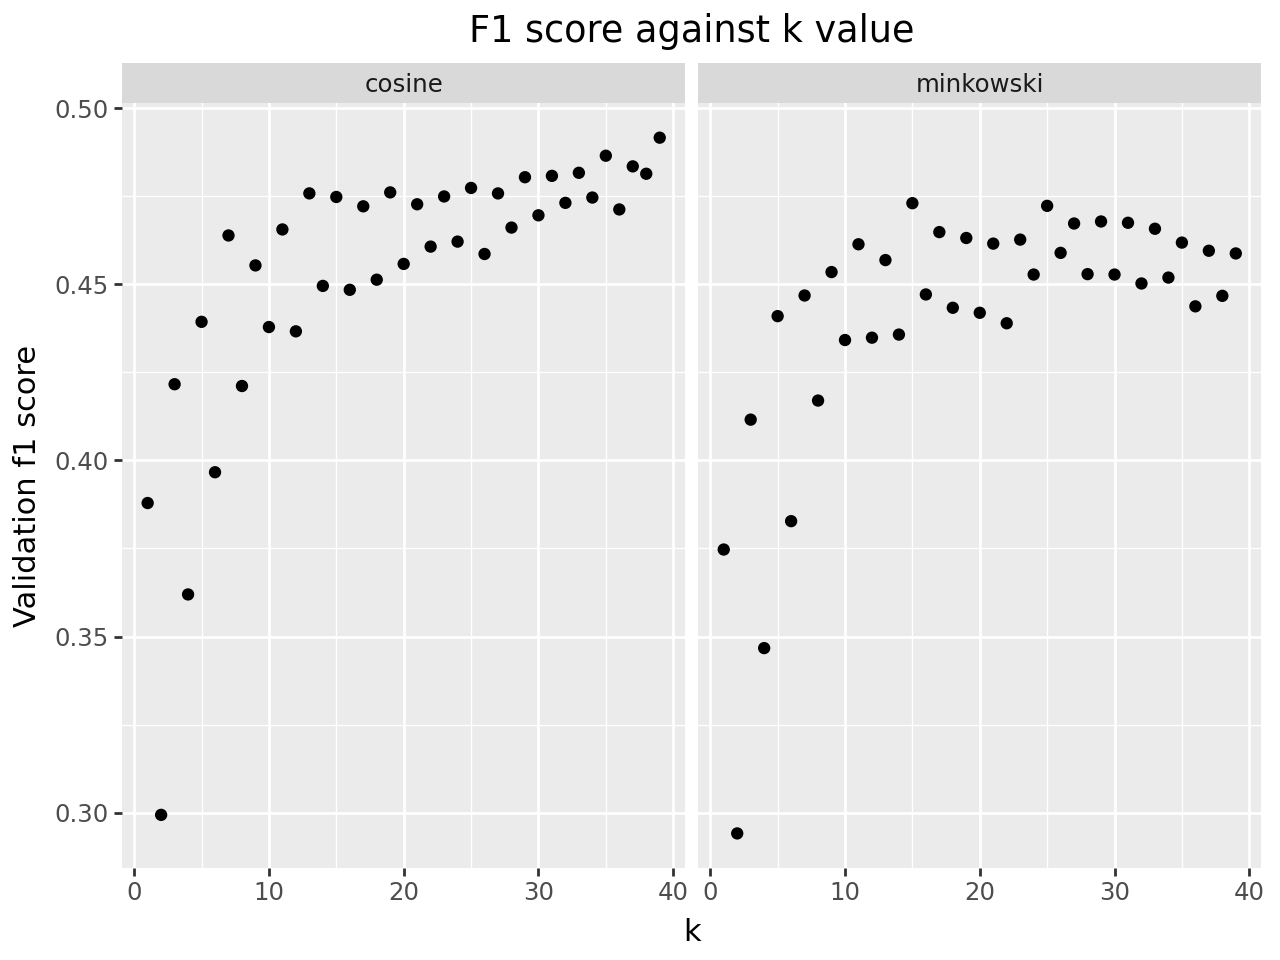

In [39]:
scores = []
for combo in hyperparameter_tuning_results:
    scores.append( (combo[0], combo[1], hyperparameter_tuning_results[combo]["score"]) )
scores_df = pd.DataFrame(scores, columns=["k", "metric", "score"])

(
    ggplot(scores_df, aes(x="k", y="score")) +
    geom_point() +
    facet_wrap("metric") +
    ggtitle("F1 score against k value") +
    ylab("Validation f1 score")
)

In [40]:
best_combo = None
best_score = 0
for combo in hyperparameter_tuning_results:
    score = hyperparameter_tuning_results[combo]['score']
    if score >= best_score:
        best_score = score
        best_combo = combo
best_score
best_combo

np.float64(0.49160671462829736)

(39, 'cosine')

In [41]:
# final model
final_knn_model = KNeighborsClassifier(n_neighbors = best_combo[0], metric = best_combo[1])
_ = final_knn_model.fit(X_train_validation, y_train_validation)
y_hat_test = final_knn_model.predict(X_test)
f1_score(y_test, y_hat_test)

np.float64(0.43722304283604135)

Now we try hyperparameter tuning, but with sklearn CV grid search: https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.GridSearchCV.html

In [42]:
# use PredefinedSplit to specify which observations are train and which are validation
fold_index = PredefinedSplit([-1]* X_train.shape[0] + [0] * X_validation.shape[0])

In [46]:
# define the parameter grid as a dictionary of lists, where the keys are the names of the parameters
param_grid = {'n_neighbors': k_grid, 'metric': distances_grid}

sklearn_grid_search = GridSearchCV(KNeighborsClassifier(), param_grid=param_grid, n_jobs=3, cv=fold_index, scoring='f1')

# # now perform the grid search on train+validation. Note that the fold_index above encodes which observations are train and which are validation
start_time = datetime.datetime.now()
sklearn_grid_search.fit(X=X_train_validation, y=y_train_validation)
end_time = datetime.datetime.now()
print(f'hypertuning with sklearn grid search complete in {round((end_time - start_time).seconds/60, 2)} minutes')

GridSearchCV(cv=PredefinedSplit(test_fold=array([-1, -1, ...,  0,  0])),
             estimator=KNeighborsClassifier(), n_jobs=3,
             param_grid={'metric': ['minkowski', 'cosine'],
                         'n_neighbors': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12,
                                         13, 14, 15, 16, 17, 18, 19, 20, 21, 22,
                                         23, 24, 25, 26, 27, 28, 29, 30, ...]},
             scoring='f1')

hypertuning with sklearn grid search complete in 0.37 minutes


In [47]:
sklearn_grid_search.best_estimator_

KNeighborsClassifier(metric='cosine', n_neighbors=39)

In [48]:
sklearn_grid_search.best_score_

np.float64(0.49160671462829736)